This chapter covers
- Computing the training and validation set losses to assess the quality of LLM-generated text during training
- Implementing a training function and pretraining the LLM
- Saving and loading model weights to continue training an LLM
- Loading pretrained weights from OpenAI

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.3
numpy version: 1.26.4
tiktoken version: 0.8.0
torch version: 2.5.1
tensorflow version: 2.18.0


In [2]:
import torch
from scripts.previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

- We use dropout of 0.1 above, but it's relatively common to train LLMs without dropout nowadays
- Modern LLMs also don't use bias vectors in the `nn.Linear` layers for the query, key, and value matrices (unlike earlier GPT models), which is achieved by setting `"qkv_bias": False`
- We reduce the context length (`context_length`) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens
  - This is so that more readers will be able to follow and execute the code examples on their laptop computer
  - However, please feel free to increase the `context_length` to 1024 tokens (this would not require any code changes)
  - We will also load a model with a 1024 `context_length` later from pretrained weights

In [3]:
model.trf_blocks[11].att.mask.shape

torch.Size([256, 256])

## Tokenizer

In [4]:
import tiktoken
from scripts.previous_chapters import generate_text_simple

In [5]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [6]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- As we can see above, the model does not produce good text because it has not been trained yet
- How do we measure or capture what "good text" is, in a numeric form, to track it during training?
- The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress
- The next chapters on finetuning LLMs will also introduce additional ways to measure model quality

## Loss: Cross Entropy and Perplexity

In [8]:
token_ids

tensor([[ 6109,  3626,  6100,   345, 34245,  5139,  2492, 25405, 17434, 17853,
          5308,  3398, 13174, 43071]])

In [7]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

Forward pass to the model

In [9]:
with torch.no_grad():
    logits = model(inputs)


In [10]:
logits.shape

torch.Size([2, 3, 50257])

In [11]:
probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary

In [12]:
torch.sum(probas, dim=-1) # Check that probabilities sum to 1

tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000]])

In [13]:
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [14]:
# Greedy
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [15]:
token_ids.shape

torch.Size([2, 3, 1])

Let's decode

In [17]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [16]:
targets[0].shape

torch.Size([3])

### How fare the outputs are to targets ?

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-index.webp" width=500px>

- The token probabilities corresponding to the target indices are as follows:

In [19]:
inputs

tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])

In [18]:
targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

In [20]:
probas.shape

torch.Size([2, 3, 50257])

In [21]:
text_idx = 0
# indices of the target tokens in the vocabulary
idxs = targets[text_idx]
target_probas_1 = probas[text_idx, [0, 1, 2], idxs]
print("Text 1:", target_probas_1)

text_idx = 1
idxs1 = targets[text_idx]
target_probas_2 = probas[text_idx, [0, 1, 2], idxs1]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- We want to maximize all these values, bringing them close to a probability of 1

- In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself; this is out of the scope of this book, but I have recorded a lecture with more details here: [L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM)

In [22]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- Take the average log prob:

In [23]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- The goal is to make this average log probability as large as possible by optimizing the model weights
- Due to the log, the largest possible value is 0, and we are currently far away from 0

- In deep learning, instead of maximizing the average log-probability, it's a standard convention **to minimize the *negative* average log-probability value**; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0
- **The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning**

In [24]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- PyTorch already implements a `cross_entropy` function that carries out the previous steps

In [25]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- For the `cross_entropy` function in PyTorch, we want to flatten these tensors by combining them over the batch dimension. We will ignore the batching and assume everything is from the same sequence length L: [L, Vocab]

In [30]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape) # size: [L, vocab_size]
print("Flattened targets:", targets_flat.shape) # size: [L]

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [27]:
targets_flat

tensor([ 3626,  6100,   345,  1107,   588, 11311])

In [37]:
l_logit_target_token = []
l_probas_target_token = []
for idx, target in enumerate(targets_flat):
    # Get the logit
    logits_token = logits_flat[idx]
    logit_target_token = logits_token[target]
    l_logit_target_token.append(logit_target_token)
    # Get probas
    probas_token = torch.softmax(logits_token, dim=-1)
    probas_target_token = probas_token[target]
    l_probas_target_token.append(probas_target_token)

In [43]:
# Concatenate in a single tensor
tensor_probas_target_token = torch.tensor(l_probas_target_token)

In [44]:
tensor_probas_target_token

tensor([7.4541e-05, 3.1061e-05, 1.1563e-05, 1.0337e-05, 5.6776e-05, 4.7559e-06])

In [48]:
final_loss = -torch.mean(torch.log(tensor_probas_target_token))

In [49]:
final_loss

tensor(10.7940)

In [50]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


### Perplexity

- A concept related to the cross-entropy loss is the perplexity of an LLM
- The perplexity is simply the exponential of the cross-entropy loss

In [51]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens)
- In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset
- Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution

# Training

In [52]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [54]:
len(text_data)

20479

In [55]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [56]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [57]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later)

### Dataset Split

- Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training
- For visualization purposes, the figure below assumes a `max_length=6`, but for the training loader, we set the `max_length` equal to the context length that the LLM supports
- The figure below only shows the input tokens for simplicity
    - Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/batching.webp" width=500px>

In [58]:
from scripts.previous_chapters import create_dataloader_v1

In [59]:
max_length = GPT_CONFIG_124M["context_length"]
print("Max length:", max_length)

Max length: 256


In [60]:
stride = GPT_CONFIG_124M["context_length"]
print("Stride:", stride)

Stride: 256


In [70]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [62]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [71]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [73]:
x[0, :10]

tensor([  518,     6, 14707,   588,   257,  2156,   286,  4116,    13,   679])

In [74]:
y[0, :10]

tensor([    6, 14707,   588,   257,  2156,   286,  4116,    13,   679,  1422])

In [64]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


### How to calculate the loss in a batch

- Next, we implement a utility function to calculate the cross-entropy loss of a given batch


In [65]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

- In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader

In [69]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))

    # Remember that GPTDatasetV1 class returns input and target in the getitem method
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [75]:
torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.98110580444336


## Training

- We focus on a simple training function (if you are interested in augmenting this training function with more advanced techniques, such as learning rate warmup, cosine annealing, and gradient clipping, please refer to [Appendix D](../../appendix-D/01_main-chapter-code))

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/train-steps.webp" width=300px>

In [78]:
x.shape

torch.Size([2, 256])

In [79]:
x.numel()

512

In [80]:
from tqdm import tqdm

In [81]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in tqdm(range(num_epochs)):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [82]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

  0%|          | 0/10 [00:00<?, ?it/s]

Ep 1 (Step 000000): Train loss 9.817, Val loss 9.928
Ep 1 (Step 000005): Train loss 8.065, Val loss 8.336


 10%|█         | 1/10 [00:00<00:05,  1.58it/s]

Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.622, Val loss 7.052
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.601


 20%|██        | 2/10 [00:01<00:04,  1.72it/s]

Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.587, Val loss 6.477


 30%|███       | 3/10 [00:01<00:03,  1.77it/s]

Ep 3 (Step 000025): Train loss 5.535, Val loss 6.404
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 5.157, Val loss 6.386


 40%|████      | 4/10 [00:02<00:03,  1.79it/s]

Ep 4 (Step 000035): Train loss 4.991, Val loss 6.385
Every effort moves you a a so a a a. Gisburn, and a. Gisburn, and a, and a.            "I the of the of the picture and he had been. I
Ep 5 (Step 000040): Train loss 4.366, Val loss 6.265


 50%|█████     | 5/10 [00:02<00:02,  1.85it/s]

Every effort moves you, I had been a--as of the--as of the of the of the, I had been--and it's had been, in the of the of the picture, as a of the of the of the man of the of the of
Ep 6 (Step 000045): Train loss 4.017, Val loss 6.201
Ep 6 (Step 000050): Train loss 3.511, Val loss 6.147


 60%|██████    | 6/10 [00:03<00:02,  1.84it/s]

Every effort moves you know the    "I looked--I had a little.             "I, and I had been the donkey.            
Ep 7 (Step 000055): Train loss 3.530, Val loss 6.175
Ep 7 (Step 000060): Train loss 2.720, Val loss 6.129


 70%|███████   | 7/10 [00:03<00:01,  1.84it/s]

Every effort moves you know the picture to see the picture.                    "I he was his pictures-c.             
Ep 8 (Step 000065): Train loss 2.279, Val loss 6.143


 80%|████████  | 8/10 [00:04<00:01,  1.83it/s]

Ep 8 (Step 000070): Train loss 1.936, Val loss 6.217
Every effort moves you know," was not that the picture.  "I had the last word. Gisburn's an!  "Oh, in the moment--as Jack himself, as he was his own the donkey. "There were days when I
Ep 9 (Step 000075): Train loss 1.559, Val loss 6.220


 90%|█████████ | 9/10 [00:04<00:00,  1.83it/s]

Ep 9 (Step 000080): Train loss 1.229, Val loss 6.245
Every effort moves you know," was not that my hostess was "interesting": on that Mrs. "Yes--and by me to me to have to see a smile behind his close that he had married her--the quality of Jack's "strongest," she was
Ep 10 (Step 000085): Train loss 0.940, Val loss 6.315


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"     "I didn't face that he had married her--the quality of the a fashionable painter--and by holding


In [84]:
train_losses

[9.817434310913086,
 8.065202045440675,
 6.622488212585449,
 6.047133350372315,
 5.58669261932373,
 5.5352483749389645,
 5.157100677490234,
 4.99132661819458,
 4.366218757629395,
 4.0169103145599365,
 3.5108954906463623,
 3.530308485031128,
 2.7198591232299805,
 2.279480051994324,
 1.9362924098968506,
 1.5586584329605102,
 1.2285195589065552,
 0.9399571537971496]

In [85]:
val_losses

[9.927745819091797,
 8.335558891296387,
 7.051747798919678,
 6.600673198699951,
 6.47714376449585,
 6.4035162925720215,
 6.38599157333374,
 6.384969711303711,
 6.264615535736084,
 6.2005839347839355,
 6.147343635559082,
 6.175339221954346,
 6.129348278045654,
 6.142926216125488,
 6.217245101928711,
 6.220163345336914,
 6.245031356811523,
 6.3148016929626465]

: 

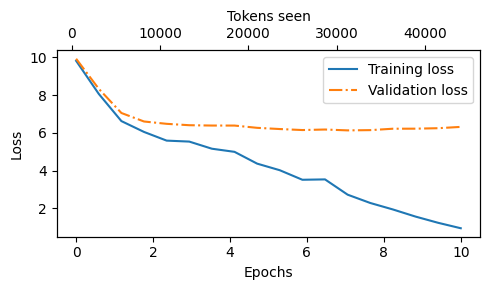

In [83]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- Looking at the results above, we can see that the model starts out generating incomprehensible strings of words, whereas towards the end, it's able to produce grammatically more or less correct sentences
- However, based on the training and validation set losses, we can see that the model starts overfitting
- If we were to check a few passages it writes towards the end, we would find that they are contained in the training set verbatim -- it simply memorizes the training data
- **Later, we will cover decoding strategies that can mitigate this memorization by a certain degree**
- Note that the overfitting here occurs because **we have a very, very small training set**, and we iterate over it so many times
  - The LLM training here primarily serves educational purposes; we mainly want to see that the model can learn to produce coherent text
  - Instead of spending weeks or months on training this model on vast amounts of expensive hardware, we load pretrained weights later